In [1]:
!pip install -q transformers
!pip install -q tqdm
!pip install --upgrade gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [3]:
corpus = 'mrpc' # 'mrpc'/'manual'

gspreadsheet = {
    'manual': '1F8DlB2sKRddAbSad4byFRBjm2Q1-pP9Xf1ePOmLkXEM',
    'mrpc': '1eX0atV1WvGkkOS-JMN5XH84IfiJoshalGmMhEwJfkY0'
}

gspreadsheet[corpus]

'1eX0atV1WvGkkOS-JMN5XH84IfiJoshalGmMhEwJfkY0'

In [4]:
folder_corpora_path = '/content/drive/My Drive/Colab Notebooks/5_Corpora/corpora/'

In [5]:
import gspread
from google.oauth2.service_account import Credentials

scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = Credentials.from_service_account_file('/content/drive/My Drive/Colab Notebooks/cedar-card-413120-c97e74ee71de.json', scopes=scope)
client = gspread.authorize(creds)

In [6]:
spreadsheet_url = f'https://docs.google.com/spreadsheets/d/{gspreadsheet[corpus]}'
sheet = client.open_by_url(spreadsheet_url).sheet1

In [7]:
import pandas as pd

# Assuming 'sheet' is the opened worksheet from gspread
data = sheet.get_all_values()
headers = data.pop(0)  # Assumes the first row is the header
df = pd.DataFrame(data, columns=headers)
df.head()

,original,positive,negative,original_label,positive_label,negative_label,original_sentiment_label,original_sentiment_score,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score
0,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",Tab shares managed a negligible climb of 19 ce...,NEU,POS,NEG,NEU,0.8141698241,POS,0.7458326221,NEG,0.8859838843
1,"The Nasdaq had a weekly gain of 17.27 , or 1.2...",The tech-laced Nasdaq Composite .IXIC rallied ...,The Nasdaq's weekly gain was a disappointing 1...,NEU,POS,NEG,NEU,0.8566916585,POS,0.5348492861,NEG,0.9432076812
2,"That compared with $ 35.18 million , or 24 cen...",That represents a significant improvement from...,Earnings were affected by a non-recurring $ 8 ...,NEU,POS,NEG,NEU,0.9731413722,POS,0.9568226933,NEG,0.6827047467
3,Shares of Xoma fell 16 percent in early trade ...,"Shares of Genentech , a much larger company wi...",Xoma's shares plummeted by 16 percent in early...,NEU,POS,NEG,NEU,0.5232236385,POS,0.8340537548,NEG,0.7182404995
4,"Gyorgy Heizler , head of the local disaster un...","Gyorgy Heizler, head of the local disaster uni...","The head of the local disaster unit , Gyorgy H...",NEU,POS,NEG,NEU,0.9681839347,POS,0.8164209723,NEG,0.7426626086


# Check duplicities

In [8]:
# Checking for duplicate sentences in the dataset
duplicate_sentences = df[df.duplicated(keep=False)]

# Displaying the duplicates if found
duplicate_sentences

,original,positive,negative,original_label,positive_label,negative_label,original_sentiment_label,original_sentiment_score,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score


# Add expected sentiment

In [9]:
df = df.drop(['original_sentiment_label','original_sentiment_score',
              'positive_sentiment_label','positive_sentiment_score',
              'negative_sentiment_label','negative_sentiment_score'], axis=1)

df['original_label'] = 'NEU'
df['positive_label'] = 'POS'
df['negative_label'] = 'NEG'

df.head()

,original,positive,negative,original_label,positive_label,negative_label
0,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",Tab shares managed a negligible climb of 19 ce...,NEU,POS,NEG
1,"The Nasdaq had a weekly gain of 17.27 , or 1.2...",The tech-laced Nasdaq Composite .IXIC rallied ...,The Nasdaq's weekly gain was a disappointing 1...,NEU,POS,NEG
2,"That compared with $ 35.18 million , or 24 cen...",That represents a significant improvement from...,Earnings were affected by a non-recurring $ 8 ...,NEU,POS,NEG
3,Shares of Xoma fell 16 percent in early trade ...,"Shares of Genentech , a much larger company wi...",Xoma's shares plummeted by 16 percent in early...,NEU,POS,NEG
4,"Gyorgy Heizler , head of the local disaster un...","Gyorgy Heizler, head of the local disaster uni...","The head of the local disaster unit , Gyorgy H...",NEU,POS,NEG


# Extract sentiment

In [10]:
from transformers import pipeline
from tqdm import tqdm
tqdm.pandas()

# Load the sentiment analysis pipeline
model = pipeline('sentiment-analysis', model="finiteautomata/bertweet-base-sentiment-analysis")
# model = pipeline('sentiment-analysis', model="ProsusAI/finbert")
# model = pipeline('sentiment-analysis', model="pysentimiento/robertuito-sentiment-analysis")
# model = pipeline('sentiment-analysis', model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")
# model = pipeline('sentiment-analysis', model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# Function to get sentiment label and score
def get_sentiment(sentence):
    result = model(sentence)[0]
    return result['label'], result['score']

# Apply the function to each sentence column and create new columns for label and score
for column in ['original', 'positive', 'negative']:
    df[[column + '_sentiment_label', column + '_sentiment_score']] = df[column].progress_apply(
        lambda x: pd.Series(get_sentiment(x))
    )

df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
100%|██████████| 1056/1056 [02:37<00:00,  6.72it/s]


,original,positive,negative,original_label,positive_label,negative_label,original_sentiment_label,original_sentiment_score,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score
0,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",Tab shares managed a negligible climb of 19 ce...,NEU,POS,NEG,NEU,0.814170,POS,0.745833,NEG,0.885984
1,"The Nasdaq had a weekly gain of 17.27 , or 1.2...",The tech-laced Nasdaq Composite .IXIC rallied ...,The Nasdaq's weekly gain was a disappointing 1...,NEU,POS,NEG,NEU,0.856692,POS,0.534849,NEG,0.943208
2,"That compared with $ 35.18 million , or 24 cen...",That represents a significant improvement from...,Earnings were affected by a non-recurring $ 8 ...,NEU,POS,NEG,NEU,0.973141,POS,0.956823,NEG,0.682705
3,Shares of Xoma fell 16 percent in early trade ...,"Shares of Genentech , a much larger company wi...",Xoma's shares plummeted by 16 percent in early...,NEU,POS,NEG,NEU,0.523224,POS,0.834054,NEG,0.718240
4,"Gyorgy Heizler , head of the local disaster un...","Gyorgy Heizler, head of the local disaster uni...","The head of the local disaster unit , Gyorgy H...",NEU,POS,NEG,NEU,0.968184,POS,0.816421,NEG,0.742663


In [ ]:
# import nltk
# nltk.download('vader_lexicon')

# from nltk.sentiment import SentimentIntensityAnalyzer
# import pandas as pd

# # Assuming df is your DataFrame and it's already defined

# # Initialize the VADER sentiment intensity analyzer
# sia = SentimentIntensityAnalyzer()

# # Function to get sentiment label and score using VADER
# def get_sentiment_vader(sentence):
#     # Get sentiment scores
#     sentiment_dict = sia.polarity_scores(sentence)

#     # Determine sentiment label based on compound score
#     if sentiment_dict['compound'] >= 0.05:
#         return 'POS', sentiment_dict['compound']
#     elif sentiment_dict['compound'] <= -0.05:
#         return 'NEG', sentiment_dict['compound']
#     else:
#         return 'NEU', sentiment_dict['compound']

# # Apply the function to each sentence column and create new columns for label and score
# for column in ['original', 'positive', 'negative']:
#     df[[column + '_sentiment_label', column + '_sentiment_score']] = df[column].progress_apply(
#         lambda x: pd.Series(get_sentiment_vader(x))
#     )


In [ ]:
# # Define the mapping of old values to new values
# sentiment_mapping = {
#     'positive': 'POS',
#     'negative': 'NEG',
#     'neutral': 'NEU'
# }

# # Column prefixes to iterate over
# prefixes = ['original', 'positive', 'negative']

# # Iterate over each prefix and apply the mapping to each corresponding column
# for prefix in prefixes:
#     column_name = f'{prefix}_sentiment_label'
#     df[column_name] = df[column_name].replace(sentiment_mapping)

# df.head()

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

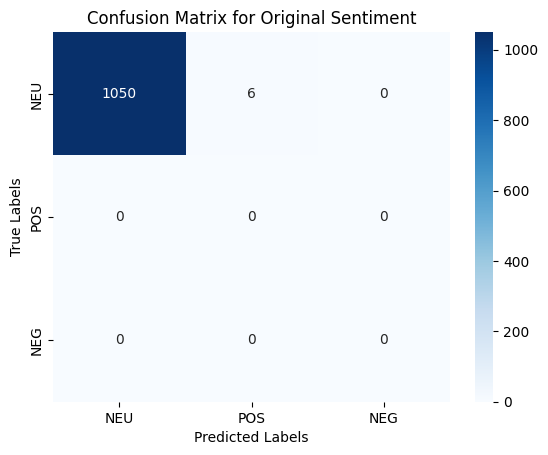

In [12]:
# Prepare the data
true_labels = df['original_label']
predicted_labels = df['original_sentiment_label']

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["NEU", "POS", "NEG"], yticklabels=["NEU", "POS", "NEG"])
plt.title('Confusion Matrix for Original Sentiment')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# plt.savefig(img_path + 'confusion_matrix_original_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
df['original_sentiment_label'].value_counts()

NEU    1050
POS       6
Name: original_sentiment_label, dtype: int64

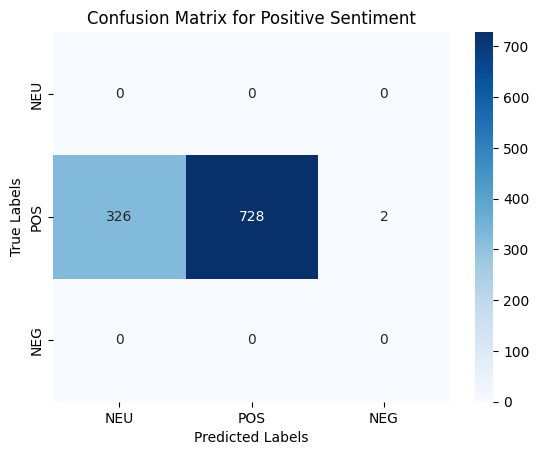

In [14]:
# Prepare the data
true_labels = df['positive_label']
predicted_labels = df['positive_sentiment_label']

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["NEU", "POS", "NEG"], yticklabels=["NEU", "POS", "NEG"])
plt.title('Confusion Matrix for Positive Sentiment')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
df['positive_sentiment_label'].value_counts()

POS    728
NEU    326
NEG      2
Name: positive_sentiment_label, dtype: int64

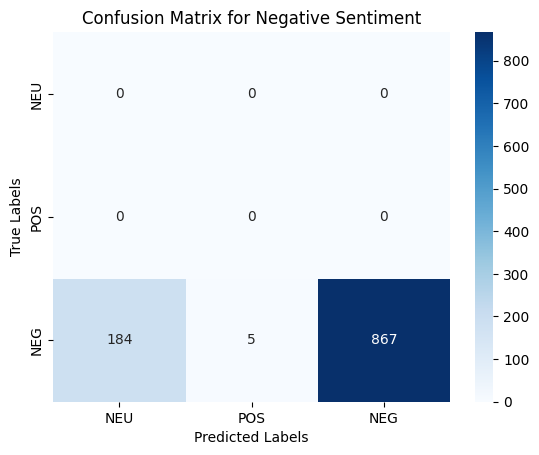

In [16]:
# Prepare the data
true_labels = df['negative_label']
predicted_labels = df['negative_sentiment_label']

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["NEU", "POS", "NEG"], yticklabels=["NEU", "POS", "NEG"])
plt.title('Confusion Matrix for Negative Sentiment')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
df['negative_sentiment_label'].value_counts()

NEG    867
NEU    184
POS      5
Name: negative_sentiment_label, dtype: int64

In [18]:
df['original'].count()

1056

# Save back to Spreadsheet and to CSV

In [19]:
sheet.clear()
# Convert the DataFrame to a list of lists, where each sublist is a row
dataframe_values = df.values.tolist()
# Reinsert headers at the beginning
dataframe_values.insert(0, df.columns.to_list())

# Update the sheet with the DataFrame's values
sheet.update('A1', dataframe_values)

<ipython-input-19-64fd9fc75093>:8: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update('A1', dataframe_values)


{'spreadsheetId': '1eX0atV1WvGkkOS-JMN5XH84IfiJoshalGmMhEwJfkY0',
 'updatedRange': 'Sheet1!A1:L1057',
 'updatedRows': 1057,
 'updatedColumns': 12,
 'updatedCells': 12684}

In [21]:
df.to_csv(folder_corpora_path + f'{corpus}-sentiment-triplet-corpus.csv', index=False)

# Identify sentiment mismatch

In [ ]:
mismatched = df[df['negative_label'] != df['negative_sentiment_label']]
pd.set_option('display.max_colwidth', None)
for sentence in mismatched['negative']:
    print(sentence)

In [ ]:
mismatched = df[df['positive_label'] != df['positive_sentiment_label']]
pd.set_option('display.max_colwidth', None)
for sentence in mismatched['positive']:
    print(sentence)

In [ ]:
mismatched = df[df['original_label'] != df['original_sentiment_label']]
pd.set_option('display.max_colwidth', None)
for sentence in mismatched['original']:
    print(sentence)

Wal-Mart reported a 4.6 percent increase in same-store sales year over year.
IBM saw its sales increase by 37 percent to 220,000 units.
Former prisoner of war Pfc. Jessica Lynch has shared her experience of being assaulted by her Iraqi captors.
The Standard & Poor's retail index saw an increase of more than 1.5 percent.
The company plans to appeal and expects a favorable outcome eventually.
The nine largest airlines generated $75.4 billion in revenue last year.
The Nasdaq Telecommunications Index increased by 0.7 percent.
Cooler, moist air entered Colorado, aiding firefighting efforts against two wildfires.
For Kathy Nicolo, the house represents stability and family.
Oracle's stock increased by 15 cents to $13.51 following news.
Cisco's stock increased by $1.28 in after-hours trading to $23.
His wife mentioned his support for George Bush and his anticipation of utilizing his training.
Breast cancer cases in Britain exceeded 40,000 for the first time.
